In [1]:
import numpy as np
import scipy.sparse as sps
import scipy.linalg as spl
import scipy.sparse.linalg as spsl
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from scipy.special import legendre

import time

In [2]:
def dat_to_xarray(file):
    """
    args :
        - file : str, path to a calypso output file
    returns :
        - ds : xarray.dataset, where dimensions have been automatically extracted
       """
    f=open(file,"r")
    header=0
    while f.readline()[:6]!="t_step":
        header+=1
    df = pd.read_table(file,header = header,delimiter = '\s+')
    all_coords=['t_step','radius_ID','degree','order','radial_id','diff_deg_order']
    coords = [cname for cname in df.columns if cname in all_coords]
    ds=df.set_index(coords).to_xarray()
    if 't_step' in coords:
        ds = ds.assign_coords({'time':ds.time.isel({c:0 for c in coords if c != 't_step'}, drop=True)})
    if 'radius_ID' in coords:
        ds = ds.assign_coords({'radius':ds.radius.isel({c:0 for c in coords if c != 'radius_ID'}, drop=True)})
    return ds
    

In [3]:
picked = dat_to_xarray("data/fullrun789/picked_mode.dat")
layered_l = dat_to_xarray("data/fullrun789/sph_pwr_layer_l.dat")
layered_m = dat_to_xarray("data/fullrun789/sph_pwr_layer_m.dat")
layered_s = dat_to_xarray("data/fullrun789/sph_pwr_layer_s.dat")
layered_l_radial = dat_to_xarray("data/radial790/sph_pwr_layer_l.dat")

In [4]:
picked
# An xarray.Dataset contains n dimensions, and any number of variables that depend on 
# one or more of these dimensions. Coordinates are variables that are uniquely mapped to one dimension,
# e.g. here t_step is the time dimenstion, and time is a coordinate. You could set 'time' as a dimension 
# if you wanted to. 
# Note that you can index an array by a dimension, but not by a coordinate :
# picked.sel(t_step=15780200) would work, but picked.sel(time=7.79302) would throw an error.

<xarray.Dataset>
Dimensions:                (degree: 3, order: 1, radius_ID: 3, t_step: 100)
Coordinates:
  * t_step                 (t_step) int64 15780200 15780400 ... 15800000
  * radius_ID              (radius_ID) int64 310 330 355
  * degree                 (degree) int64 3 4 5
  * order                  (order) int64 3
    time                   (t_step) float64 7.793 7.793 7.793 ... 7.795 7.795
    radius                 (radius_ID) float64 1.49 1.52 1.538
Data variables:
    velocity_pol           (t_step, radius_ID, degree, order) float64 -0.158 ...
    velocity_tor           (t_step, radius_ID, degree, order) float64 -0.4467...
    velocity_pol_dr        (t_step, radius_ID, degree, order) float64 0.1123 ...
    temperature            (t_step, radius_ID, degree, order) float64 0.00073...
    magnetic_field_pol     (t_step, radius_ID, degree, order) float64 -0.0016...
    magnetic_field_tor     (t_step, radius_ID, degree, order) float64 -0.0312...
    magnetic_field_pol_dr  (t_step, radius_ID, degree, order) float64 0.03767...
    pressure               (t_step, radius_ID, degree, order) float64 6.654 ....
    vorticity_pol          (t_step, radius_ID, degree, order) float64 -0.4467...
    vorticity_tor          (t_step, radius_ID, degree, order) float64 -328.1 ...
    vorticity_pol_dr       (t_step, radius_ID, degree, order) float64 -26.4 ....
    heat_source            (t_step, radius_ID, degree, order) float64 0.0 ......
    buoyancy_flux          (t_step, radius_ID, degree, order) float64 -1.282e...
    heat_advect            (t_step, radius_ID, degree, order) float64 22.45 ....
    inertia_pol            (t_step, radius_ID, degree, order) float64 2.819e+...
    inertia_tor            (t_step, radius_ID, degree, order) float64 1.124e+...
    inertia_pol_dr         (t_step, radius_ID, degree, order) float64 1.82e+0...
    Lorentz_force_pol      (t_step, radius_ID, degree, order) float64 7.455e+...
    Lorentz_force_tor      (t_step, radius_ID, degree, order) float64 5.026e+...
    Lorentz_force_pol_dr   (t_step, radius_ID, degree, order) float64 -1.669e...

# Plotting picked modes / layered power spectra 

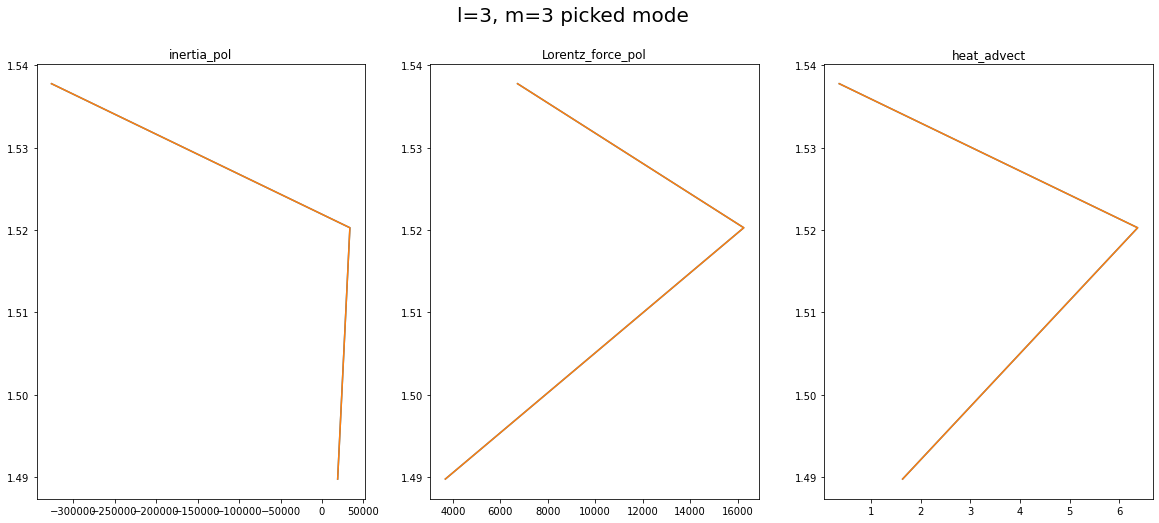

In [5]:
fig,ax=plt.subplots(1,3,figsize=(20,8))

for a,var in zip(ax,['inertia_pol','Lorentz_force_pol','heat_advect']):
    a.plot(picked[var].sel(degree=3).mean('t_step').squeeze(),picked.radius)
    a.plot(picked[var].sel(degree=3).mean('t_step').squeeze(),picked.radius)
    a.set_title(var)
fig.suptitle("l=3, m=3 picked mode ", fontsize=20); None

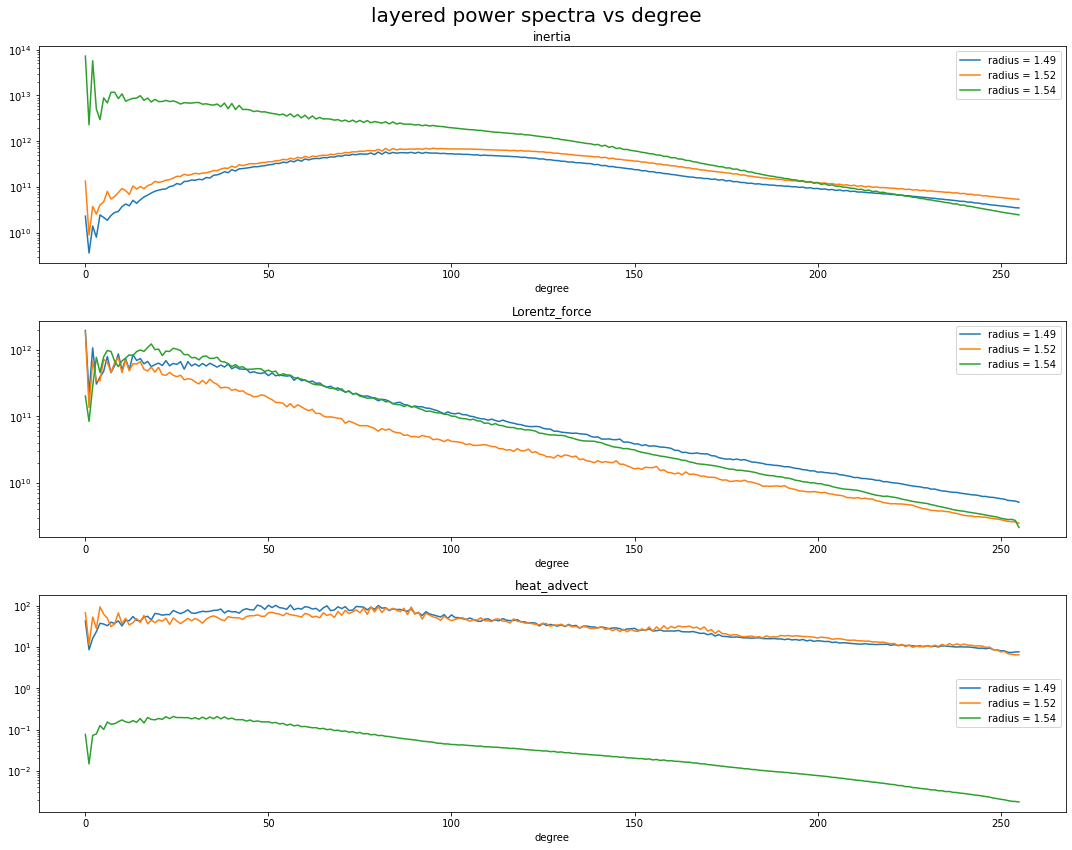

In [6]:
fig,ax=plt.subplots(3,1,figsize=(15,12))

for a,var in zip(ax,['inertia','Lorentz_force','heat_advect']):
    for i in range(3):
        a.plot(layered_l.degree,layered_l[var].isel(radial_id=i).mean('t_step').squeeze(),label="radius = %.2f"%picked.radius[i])
    a.set_title(var)
    a.set_xlabel('degree')
    a.set_yscale('log')
    a.legend()
fig.tight_layout()
fig.suptitle("layered power spectra vs degree", fontsize=20); None
fig.tight_layout()

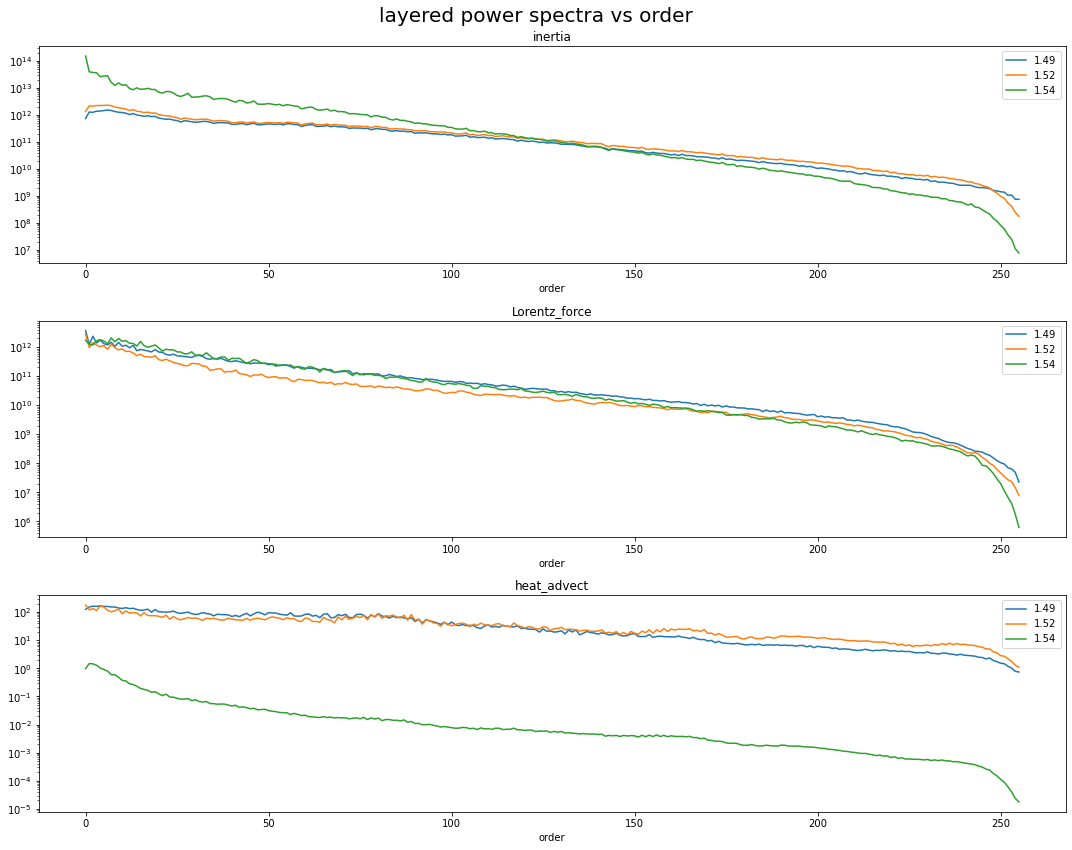

In [7]:
fig,ax=plt.subplots(3,1,figsize=(15,12))

for a,var in zip(ax,['inertia','Lorentz_force','heat_advect']):
    for i in range(3):
        a.plot(layered_m.order,layered_m[var].isel(radial_id=i).mean('t_step').squeeze(),label="%.2f"%picked.radius[i])
    a.set_title(var)
    a.set_xlabel('order')
    a.set_yscale('log')
    a.legend()
fig.tight_layout()
fig.suptitle("layered power spectra vs order", fontsize=20); None
fig.tight_layout()

# Radial dependence of the forcings

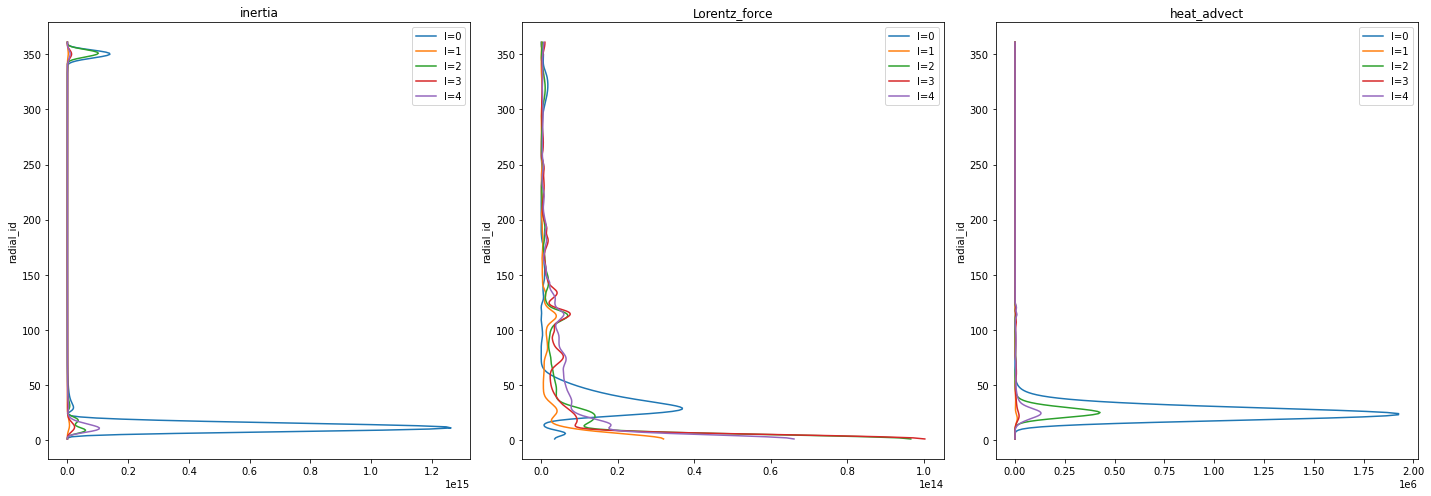

In [13]:
fig,ax=plt.subplots(1,3,figsize=(20,7))

for a,var in zip(ax,['inertia','Lorentz_force','heat_advect']):
    for i in range(5):
        a.plot(layered_l_radial[var].isel(degree=i).mean('t_step').squeeze(),layered_l_radial.radial_id,label="l=%i"%layered_l_radial.degree[i])
    a.set_title(var)
    a.set_ylabel('radial_id')
    a.legend()
fig.tight_layout()

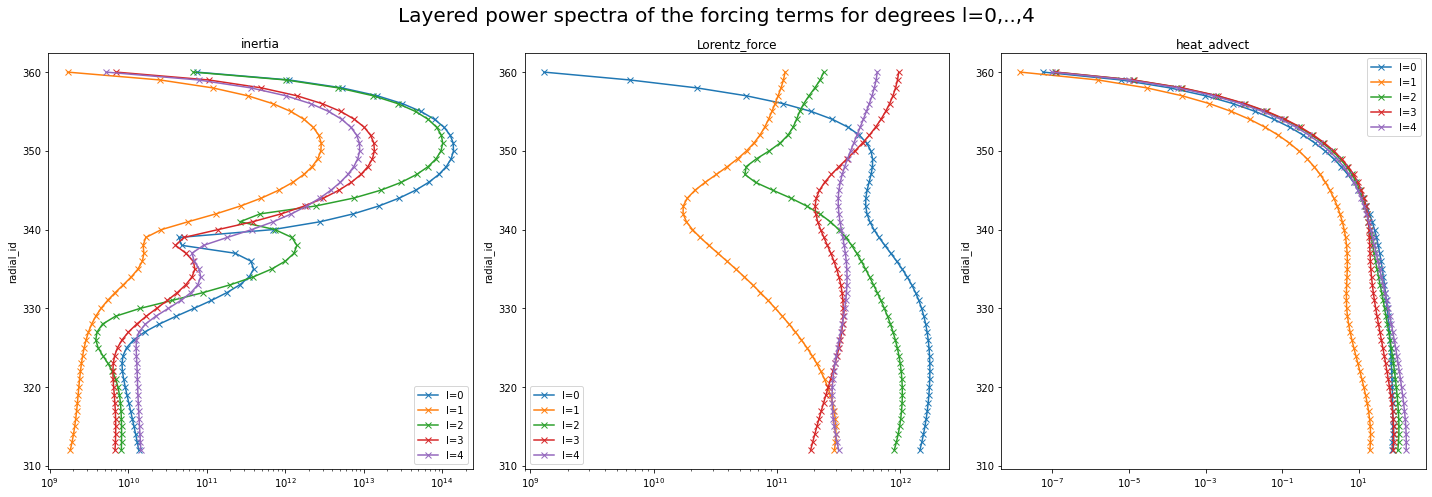

In [16]:
# Zooming into the stratified layer
fig,ax=plt.subplots(1,3,figsize=(20,7))

for a,var in zip(ax,['inertia','Lorentz_force','heat_advect']):
    for i in range(5):
        a.plot(layered_l_radial[var].isel(degree=i,radial_id=slice(-50,-1)).mean('t_step').squeeze(),layered_l_radial.radial_id[-50:-1],'-x',label="l=%i"%i)
    a.set_title(var)
    a.set_ylabel('radial_id')
    a.legend()
    a.set_xscale('log')
fig.suptitle("Layered power spectra of the forcing terms for degrees l=0,..,4",fontsize=20)
fig.tight_layout()



# Time series of the inertial term power close to CMB

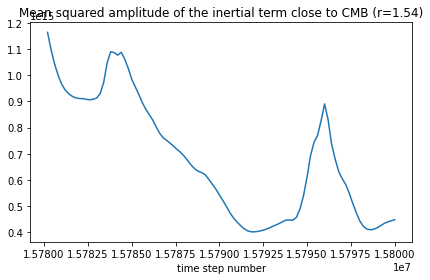

In [17]:
plt.plot(layered_s.t_step,layered_s.inertia.sel(radial_id=355).squeeze())
plt.title("Mean squared amplitude of the inertial term close to CMB (r=1.54)")
plt.xlabel("time step number")
plt.tight_layout()